# Pre-Processing, Modeling, Data Visualization & EDA

### Pre-Processing

In [1]:
# Imports for pre-processing
import numpy as np
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Imports for modeling
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers.normalization import BatchNormalization

# Imports for data visualization
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix

# Imports for ResNet50
from keras.applications.resnet50 import ResNet50
from keras.layers import Dropout
from keras.models import Model
from keras import optimizers

# Imports for EfficientNet-B0
from tensorflow.keras.applications import EfficientNetB0
from keras.layers import Activation
from keras.optimizers import Adam

# Imports for EDA
from numpy import expand_dims

# For reproducibility
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# Visualization style
plt.style.use('ggplot')

In [2]:
# Create a list for each food class
burgers_list = []
hotdogs_list = []
pizza_list = []
tacos_list = []
sushi_list = []

# Create a list of all food class lists
class_list = [burgers_list, hotdogs_list, pizza_list, tacos_list, sushi_list]

# Create a list of strings containing the food classes
food_classes = ['burgers', 'hotdogs', 'pizza', 'tacos', 'sushi']

In [3]:
# Referenced: https://git.generalassemb.ly/DSIR-Lancelot/8.04-lesson-cnns/blob/master/solution-code/02-cnn.ipynb
# Define a function that converts all images
def image_converter(food_list, food_class):
    food_path = f'../images/{food_class}/'
    for file in os.listdir(food_path):
        try:
            image = load_img(food_path + file, target_size=(224, 224))
            image_arr = img_to_array(image) / 255
            food_list.append(image_arr)
        except:
            print(f'Error for file: {file}')
    print(f'{len(food_list)} pictures have been converted for {food_class}.')

**Note:** The target size of the image is the first hyperparameter. A multiple of 32 usually works well. Target sizes I considered and tested include: 224x224, 256x256, 384x384, and 512x512. The main reasons I chose 224x224 were that (1) the lower the size, the less time it takes my local environment to process and (2) 224x224 is the default size for ResNet50 and EfficientNet-B0.

In [4]:
# Iterate through the image_converter function for each food class
my_index = 0
for food_class in class_list:
    image_converter(food_class, food_classes[my_index])
    my_index += 1

Error for file: .DS_Store
282 pictures have been converted for burgers.
Error for file: .DS_Store
253 pictures have been converted for hotdogs.
Error for file: .DS_Store
276 pictures have been converted for pizza.
Error for file: .DS_Store
260 pictures have been converted for tacos.
Error for file: .DS_Store
268 pictures have been converted for sushi.


### Modeling

#### Null Model

In [5]:
# Baseline accuracy of the majority class
282/(282+253+276+260+268)

0.210604929051531

**Interpretation:** The baseline accuracy of the majority class (i.e. burgers) is 21.06%. At a minimum, the production model must have an accuracy score that exceeds that of the null model.

#### Model 1: CNN with 9 layers

In [6]:
# Define X
X = burgers_list + hotdogs_list + pizza_list + tacos_list + sushi_list
X = np.array(X)
print(f'X shape: {X.shape}')

# Define y
# 0 for burgers, 1 for hotdogs, 2 for pizza, 3 for tacos, 4 for sushi
y = [0]*282 + [1]*253 + [2]*276 + [3]*260 + [4]*268
y = np.array(y)
y = to_categorical(y)
print(f'y shape: {y.shape}')

X shape: (1339, 224, 224, 3)
y shape: (1339, 5)


In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [8]:
# Reshape
X_train = np.array(X_train)
X_test = np.array(X_test)

# Check shape
print(f'X train shape: {X_train[0].shape}')
print(f'y train shape: {y_train.shape}')

X train shape: (224, 224, 3)
y train shape: (1004, 5)


In [9]:
# Referenced: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# Referenced: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
# Image data augmentation

aug = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.15,
    shear_range=0.15
)

**Notes:** All of the arguments set in the ImageDataGenerator are hyperparameters.
- width_shift_range and height_shift_range: control the amount of horizontal and vertical shift, respectively
- horizontal_flip: reverses the columns of pixels
- rotation_range: rotates the image clockwise by a given number of degrees
- zoom_range: 1.0 has no effect on zoom. >1.0 zooms out (interpolates pixels), <1.0 zooms in (adds new pixels)
- shear_range: shear intensity

In [10]:
# Referenced: https://git.generalassemb.ly/DSIR-Lancelot/8.04-lesson-cnns/blob/master/solution-code/02-cnn.ipynb
# Model architecture
cnn1 = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(X_train[0].shape)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(units=64, activation='relu'),
    Dense(units=5, activation='softmax')
])

# Compile the cnn1
cnn1.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy', 'Recall', 'Precision'])

# Fit the model
results = cnn1.fit(aug.flow(X_train, y_train, batch_size=8), 
                    validation_data=(X_test, y_test),
                    batch_size=8, epochs=25)

Epoch 1/25
126/126 [==============================] - 120s 932ms/step - loss: 2.9922 - accuracy: 0.1932 - recall: 0.0155 - precision: 0.1250 - val_loss: 1.6002 - val_accuracy: 0.2687 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/25
126/126 [==============================] - 103s 810ms/step - loss: 1.6117 - accuracy: 0.2252 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.5989 - val_accuracy: 0.2716 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/25
126/126 [==============================] - 102s 809ms/step - loss: 1.6001 - accuracy: 0.2521 - recall: 0.0011 - precision: 0.1920 - val_loss: 1.5900 - val_accuracy: 0.2746 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/25
126/126 [==============================] - 100s 789ms/step - loss: 1.5810 - accuracy: 0.2655 - recall: 0.0059 - precision: 0.3504 - val_loss: 1.5520 - val_accuracy: 0.2925 - val_recall: 0.0269 - val_precision: 0.6923
Epoch 5/25
126/126 [==============================] - 99

**Interpretation:** The architecture of the convolutional neural network above is quite simple. The model contains an input layer, two convolutional layers, two pooling layers, a fully connected/dense layer, and a softmax layer that returns the output. Despite its simplicity, the model achieved an accuracy of 45.37% on unseen data, which exceeds that of the null model by 2.15x. The training and validation accuracies are fairly similar, which indicate that the bias-variance tradeoff is well-balanced in this case. CNNs involve lots of hyperparameters that can be tuned via Hyperas. However, tuning the hyperparameters of a CNN is one of the most computationally expensive tasks that can be done. Given the time and budgetary limitations of this project, I will not attempt to tune the hyperparameters for an optimal combination.

In [11]:
# Check model summary
cnn1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 186624)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                11944000  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 3

### Data Visualization

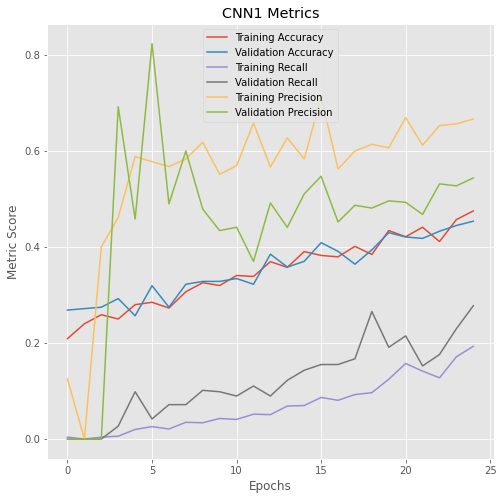

In [12]:
# Plot accuracy, recall, and precision
plt.figure(figsize=(8,8))

plt.plot(results.history['accuracy'], label='Training Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')

plt.plot(results.history['recall'], label='Training Recall')
plt.plot(results.history['val_recall'], label='Validation Recall')

plt.plot(results.history['precision'], label='Training Precision')
plt.plot(results.history['val_precision'], label='Validation Precision')

plt.title('CNN1 Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metric Score')
plt.legend();

**Interpretation:** Accuracy, recall, and precision have been plotted over 25 epochs. The validation accuracy appears to grow linearly.

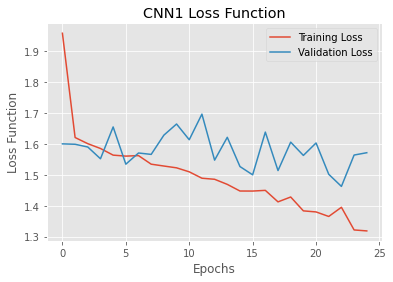

In [13]:
# Plot loss function
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')

plt.title('CNN1 Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend();

**Interpretation:** The loss function is plotted above. The ideal value for a loss function is 0.

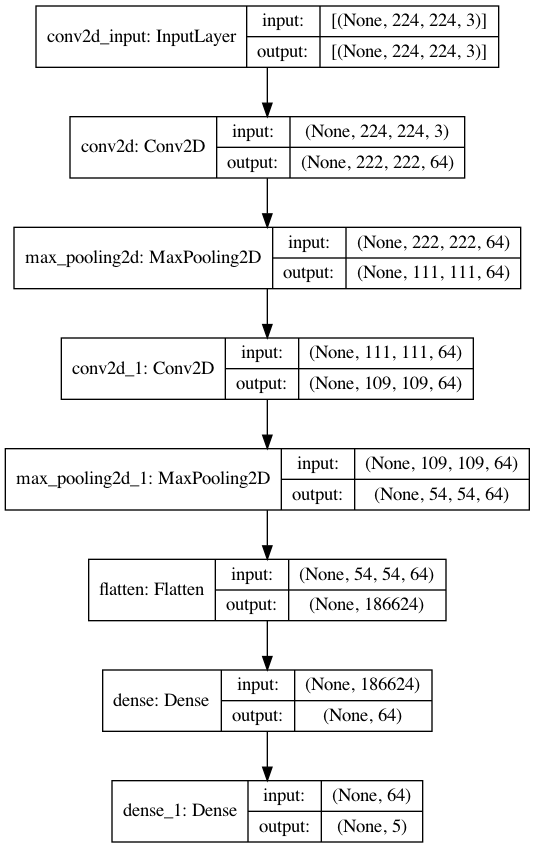

In [14]:
# Referenced: https://git.generalassemb.ly/DSIR-Lancelot/8.02-lesson-tensorflow-keras/blob/master/starter-code-Adi-InClass.ipynb
# Visualize model layers
plot_model(cnn1, show_layer_names=True, show_shapes=True)

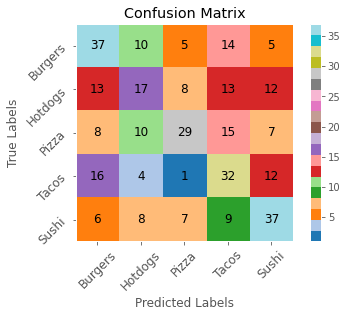

In [15]:
# Referenced: https://github.com/clairehester/face-mask-detector/blob/main/code/02_face_mask_detector.ipynb
# Plot multiclass confusion matrix
preds = cnn1.predict(X_test, batch_size=8)
preds = np.argmax(preds, axis=1)

cm = confusion_matrix(y_test.argmax(axis=1), preds)
plt.imshow(cm, cmap='tab20', interpolation='nearest')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(cm)), ['Burgers', 'Hotdogs', 'Pizza', 'Tacos', 'Sushi'], rotation=45, size='large')
plt.yticks(np.arange(len(cm)), ['Burgers', 'Hotdogs', 'Pizza', 'Tacos', 'Sushi'], rotation=45, size='large')
plt.grid(None)
plt.colorbar()

for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i, j], ha='center', va='center', size='large')

plt.show()

**Interpretation:** A multiclass confusion matrix has been plotted above. Model 1 did a great job at predicting burger when the image was actually a burger and sushi when the image was actually sushi. The model performed the worst at predicting burger when the image was actually a taco.

#### Model 2: CNN with 15 layers

In [16]:
# Referenced: https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7
# Referenced: https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
# Model architecture
cnn2 = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', 
           padding='same', input_shape=(X_train[0].shape)),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu',
          padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(5, activation='softmax')
])

# Compile the model
cnn2.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy', 'Recall', 'Precision'])

# Fit the model
results2 = cnn2.fit(aug.flow(X_train, y_train, batch_size=8), 
                    validation_data=(X_test, y_test), 
                    batch_size=8, epochs=25)

Epoch 1/25
126/126 [==============================] - 209s 2s/step - loss: 2.6075 - accuracy: 0.2223 - recall: 0.1477 - precision: 0.2395 - val_loss: 2.3505 - val_accuracy: 0.2388 - val_recall: 0.1821 - val_precision: 0.2574
Epoch 2/25
126/126 [==============================] - 206s 2s/step - loss: 1.5602 - accuracy: 0.3598 - recall: 0.1664 - precision: 0.4893 - val_loss: 1.7318 - val_accuracy: 0.2597 - val_recall: 0.0418 - val_precision: 0.3500
Epoch 3/25
126/126 [==============================] - 204s 2s/step - loss: 1.5678 - accuracy: 0.3653 - recall: 0.1562 - precision: 0.4381 - val_loss: 1.9421 - val_accuracy: 0.2597 - val_recall: 0.1582 - val_precision: 0.3064
Epoch 4/25
126/126 [==============================] - 206s 2s/step - loss: 1.5127 - accuracy: 0.3676 - recall: 0.1310 - precision: 0.4189 - val_loss: 1.9053 - val_accuracy: 0.2955 - val_recall: 0.2418 - val_precision: 0.3682
Epoch 5/25
126/126 [==============================] - 206s 2s/step - loss: 1.4289 - accuracy: 0.3827

**Interpretation:** Model 2 was built using 15 layers in total. It achieved an accuracy of 33.13% on unseen data, beating that of the null model by 1.57x. This model is clearly overfit, as seen in the difference between the training and validation accuracies. Furthermore, Model 2 would have benefitted from an early stopping callback since its validation accuracy peaked at 54.33% before falling off near the end of the 25 epochs.

In [17]:
# Check model summary
cnn2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 110, 110, 64)      18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 108, 108, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 108, 108, 64)     

### Data Visualization

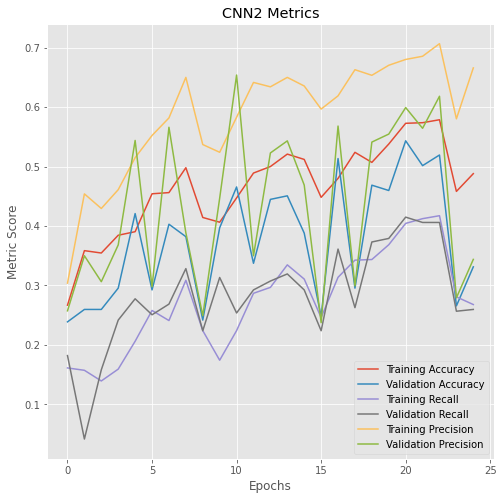

In [18]:
# Plot accuracy, recall, and precision
plt.figure(figsize=(8,8))

plt.plot(results2.history['accuracy'], label='Training Accuracy')
plt.plot(results2.history['val_accuracy'], label='Validation Accuracy')

plt.plot(results2.history['recall'], label='Training Recall')
plt.plot(results2.history['val_recall'], label='Validation Recall')

plt.plot(results2.history['precision'], label='Training Precision')
plt.plot(results2.history['val_precision'], label='Validation Precision')

plt.title('CNN2 Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metric Score')
plt.legend();

**Interpretation:** Accuracy, recall, and precision have been plotted over 25 epochs.

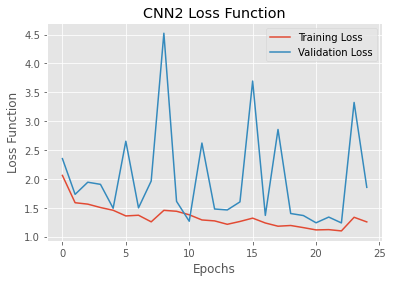

In [19]:
# Plot loss function
plt.plot(results2.history['loss'], label='Training Loss')
plt.plot(results2.history['val_loss'], label='Validation Loss')

plt.title('CNN2 Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend();

**Interpretation:** The loss function is plotted above.

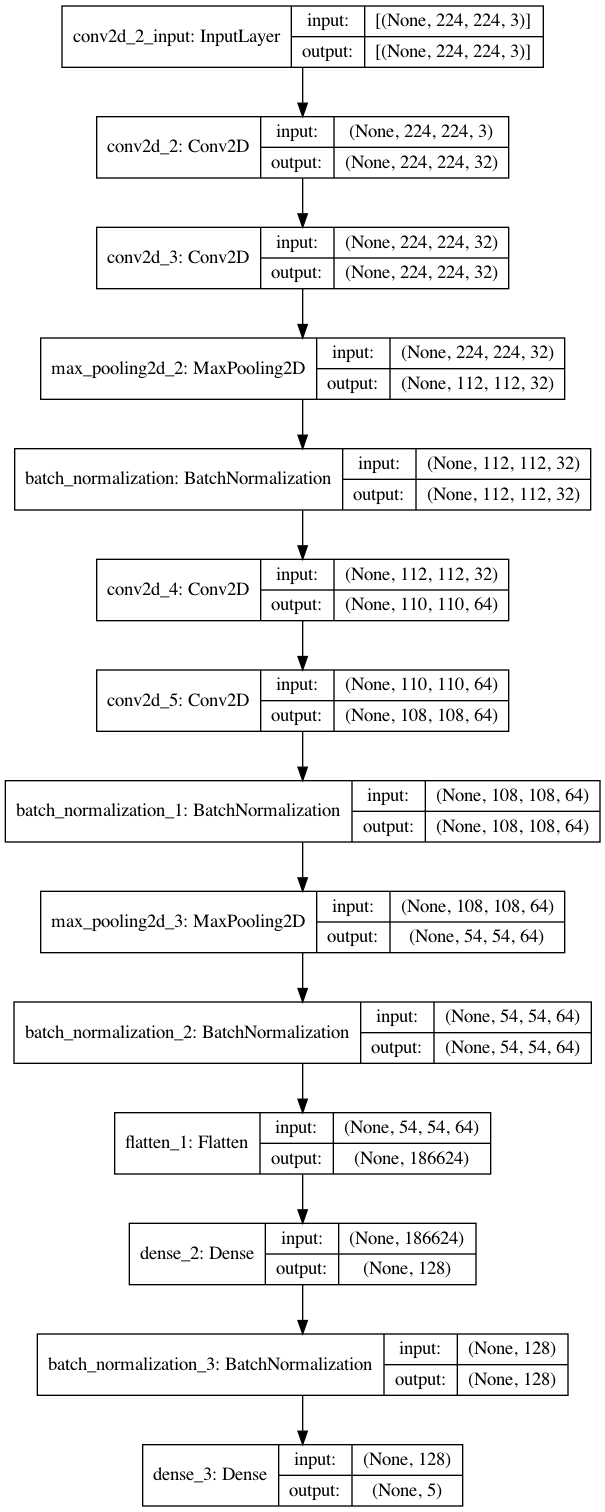

In [20]:
# Visualize model layers
plot_model(cnn2, show_layer_names=True, show_shapes=True)

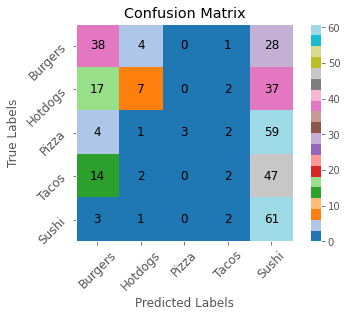

In [21]:
# Plot multiclass confusion matrix
preds2 = cnn2.predict(X_test, batch_size=8)
preds2 = np.argmax(preds2, axis=1)

cm2 = confusion_matrix(y_test.argmax(axis=1), preds2)
plt.imshow(cm2, cmap='tab20', interpolation='nearest')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(cm2)), ['Burgers', 'Hotdogs', 'Pizza', 'Tacos', 'Sushi'], rotation=45, size='large')
plt.yticks(np.arange(len(cm2)), ['Burgers', 'Hotdogs', 'Pizza', 'Tacos', 'Sushi'], rotation=45, size='large')
plt.grid(None)
plt.colorbar()

for i in range(len(cm2)):
    for j in range(len(cm2)):
        plt.text(j, i, cm2[i, j], ha='center', va='center', size='large')

plt.show()

**Interpretation:** A multiclass confusion matrix has been plotted above. Model 2 performed the best at accurately predicting sushi and performed the worst at learning the features of pizza and tacos.

#### Model 3: Transfer Learning with ResNet50

In [22]:
# Referenced: https://towardsdatascience.com/deep-learning-using-transfer-learning-python-code-for-resnet50-8acdfb3a2d38
# Image data augmentation
train_datagen = ImageDataGenerator(width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=20,
                                   zoom_range=0.15,
                                   shear_range=0.15) 
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=8)
val_generator = val_datagen.flow(X_test, y_test, batch_size=8)

In [23]:
# Model architecture
resnet = ResNet50(include_top=False, weights='imagenet',
                  input_shape=X_train[0].shape)

output = resnet.layers[-1].output
output = Flatten()(output)

resnet = Model(inputs=resnet.input, outputs=output)

for layer in resnet.layers:
    layer.trainable = False
    
cnn3 = Sequential([
    resnet,
    Dense(units=64, activation='relu', input_dim=X_train[0].shape),
    Dropout(rate=0.5), # 0.2, 0.3
    Dense(units=64, activation='relu'),
    Dropout(rate=0.3), # 0.2, 0.3
    Dense(units=5, activation='softmax')
])

cnn3.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy', 'Recall', 'Precision'])

results3 = cnn3.fit_generator(generator=train_generator, 
                              validation_data=val_generator,
                              epochs=25)

/Users/seungwoochoi/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
126/126 [==============================] - 187s 1s/step - loss: 1.8073 - accuracy: 0.1958 - recall: 0.0235 - precision: 0.2102 - val_loss: 1.6140 - val_accuracy: 0.2030 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/25
126/126 [==============================] - 181s 1s/step - loss: 1.6159 - accuracy: 0.1883 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.5927 - val_accuracy: 0.2806 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/25
126/126 [==============================] - 183s 1s/step - loss: 1.6197 - accuracy: 0.2137 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.5994 - val_accuracy: 0.2716 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/25
126/126 [==============================] - 185s 1s/step - loss: 1.6107 - accuracy: 0.2108 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.5976 - val_accuracy: 0.2657 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/25
126/126 [========================

**Interpretation:** Model 3 utilizes IBM's pre-trained ResNet50 model to learn about my image data. The model attained an accuracy of 28.66% on unseen data, which is higher than that of the null model by 1.36x. While the training and validation accuracies are quite similar, the model is underfit and does not do a great job at predicting the correct classes. This model likely would have benefitted from additional hyperparameter tuning.

In [24]:
# Check model summary
cnn3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 100352)            23587712  
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6422592   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 325       
Total params: 30,014,789
Trainable params: 6,427,077
Non-trainable params: 23,587,712
__________________________________

### Data Visualization

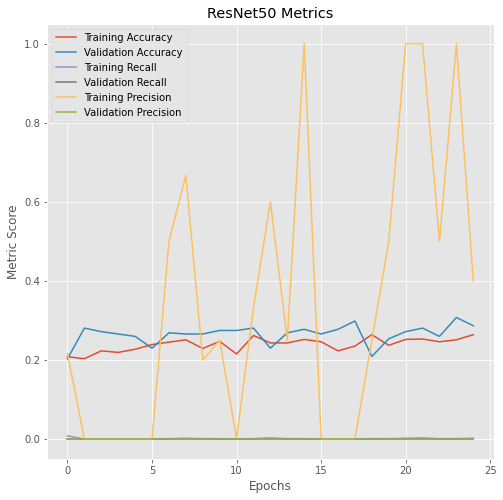

In [25]:
# Plot accuracy, recall, and precision
plt.figure(figsize=(8,8))

plt.plot(results3.history['accuracy'], label='Training Accuracy')
plt.plot(results3.history['val_accuracy'], label='Validation Accuracy')

plt.plot(results3.history['recall'], label='Training Recall')
plt.plot(results3.history['val_recall'], label='Validation Recall')

plt.plot(results3.history['precision'], label='Training Precision')
plt.plot(results3.history['val_precision'], label='Validation Precision')

plt.title('ResNet50 Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metric Score')
plt.legend();

**Interpretation:** Accuracy, recall, and precision have been plotted over 25 epochs.

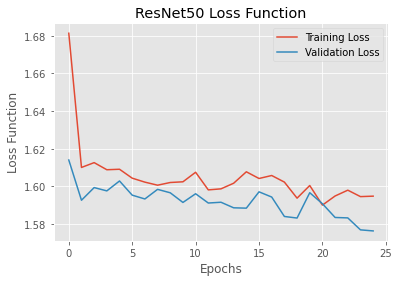

In [26]:
# Plot loss function
plt.plot(results3.history['loss'], label='Training Loss')
plt.plot(results3.history['val_loss'], label='Validation Loss')

plt.title('ResNet50 Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend();

**Interpretation:** The loss function is plotted above.

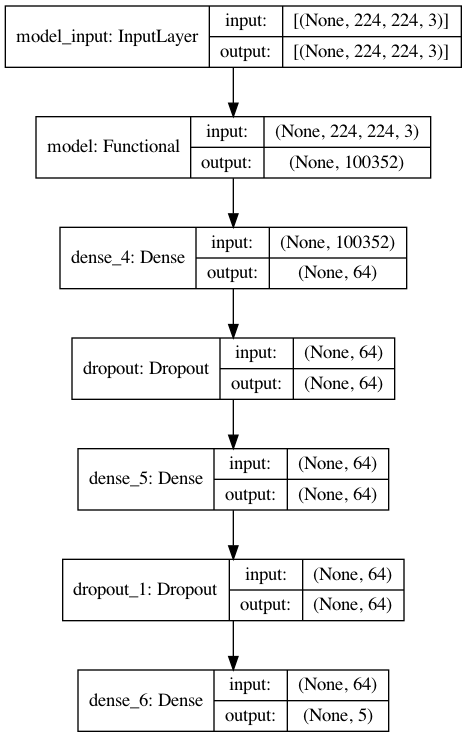

In [27]:
# Visualize model layers
plot_model(cnn3, show_layer_names=True, show_shapes=True)

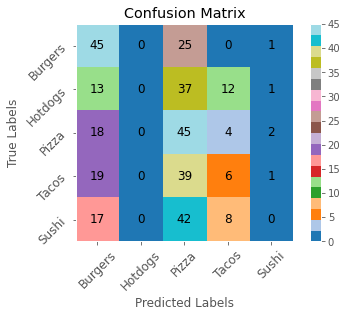

In [28]:
# Plot multiclass confusion matrix
preds3 = cnn3.predict(X_test, batch_size=8)
preds3 = np.argmax(preds3, axis=1)

cm3 = confusion_matrix(y_test.argmax(axis=1), preds3)
plt.imshow(cm3, cmap='tab20', interpolation='nearest')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(cm3)), ['Burgers', 'Hotdogs', 'Pizza', 'Tacos', 'Sushi'], rotation=45, size='large')
plt.yticks(np.arange(len(cm3)), ['Burgers', 'Hotdogs', 'Pizza', 'Tacos', 'Sushi'], rotation=45, size='large')
plt.grid(None)
plt.colorbar()

for i in range(len(cm3)):
    for j in range(len(cm3)):
        plt.text(j, i, cm3[i, j], ha='center', va='center', size='large')

plt.show()

**Interpretation:** A multiclass confusion matrix has been plotted above. The pre-trained ResNet50 model performed the best at correctly predicting burgers and pizza. However, the model failed to learn how to predict hotdogs and sushi during the 25 epochs.

#### Model 4: Transfer Learning with EfficientNet-B0

In [29]:
# Referenced: https://github.com/ayyucekizrak/EfficientNet-Transfer-Learning-Implementation/blob/master/EfficientNet_TransferLearning.ipynb
# Model architecture
cnn4 = EfficientNetB0(include_top=False, pooling='avg', 
                      weights='imagenet', input_shape=X_train[0].shape)

x = cnn4.output

x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

output = Dense(5, activation='softmax')(x)

effnet = Model(inputs=cnn4.input, outputs=output)

effnet.compile(loss='categorical_crossentropy', 
               optimizer=Adam(learning_rate=0.0001),
               metrics=['accuracy', 'Recall', 'Precision'])

results4 = effnet.fit(aug.flow(X_train, y_train, batch_size=8),
                      validation_data=(X_test, y_test),
                      batch_size=8, epochs=25)

Epoch 1/25
126/126 [==============================] - 324s 2s/step - loss: 1.8577 - accuracy: 0.2139 - recall: 0.0627 - precision: 0.2329 - val_loss: 1.6199 - val_accuracy: 0.1940 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/25
126/126 [==============================] - 305s 2s/step - loss: 1.5742 - accuracy: 0.3439 - recall: 0.1074 - precision: 0.4008 - val_loss: 1.6325 - val_accuracy: 0.2060 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/25
126/126 [==============================] - 301s 2s/step - loss: 1.2610 - accuracy: 0.4992 - recall: 0.2617 - precision: 0.6533 - val_loss: 1.7629 - val_accuracy: 0.2060 - val_recall: 0.0716 - val_precision: 0.2449
Epoch 4/25
126/126 [==============================] - 303s 2s/step - loss: 1.1047 - accuracy: 0.5710 - recall: 0.3619 - precision: 0.7576 - val_loss: 1.3625 - val_accuracy: 0.4448 - val_recall: 0.2657 - val_precision: 0.5669
Epoch 5/25
126/126 [==============================] - 303s 2s/step - loss: 1.0171 - 

**Interpretation:** Model 4 uses Google's pre-trained EfficientNet-B0 model to predict food classes. The model achieved an accuracy of 64.78% on unseen data, which is 3.07x higher than that of the null model. The difference in the training and validation accuracies indicate that the model is quite overfit. While the model has incredible performance, the fluctuations in its performance are massive as well, making the model a little less reliable in prediction.

In [30]:
# # Check model summary (uncomment to run)
# effnet.summary()

### Data Visualization

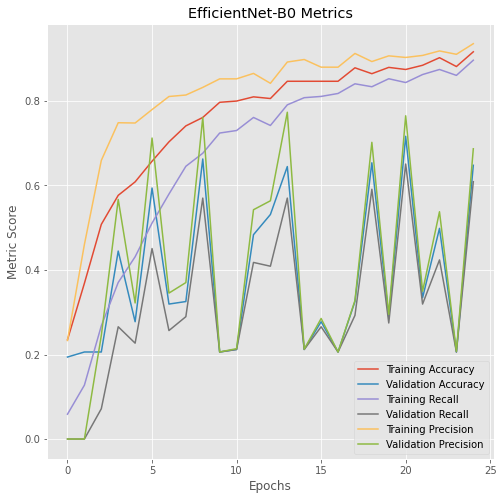

In [31]:
# Plot accuracy, recall, and precision
plt.figure(figsize=(8,8))

plt.plot(results4.history['accuracy'], label='Training Accuracy')
plt.plot(results4.history['val_accuracy'], label='Validation Accuracy')

plt.plot(results4.history['recall'], label='Training Recall')
plt.plot(results4.history['val_recall'], label='Validation Recall')

plt.plot(results4.history['precision'], label='Training Precision')
plt.plot(results4.history['val_precision'], label='Validation Precision')

plt.title('EfficientNet-B0 Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metric Score')
plt.legend();

**Interpretation:** Accuracy, recall, and precision have been plotted over 25 epochs. The fluctuations in the validation precision, validation accuracy, and validation recall are wild.

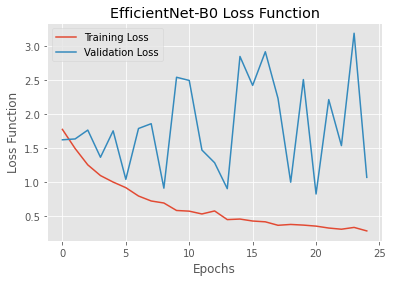

In [32]:
# Plot loss function
plt.plot(results4.history['loss'], label='Training Loss')
plt.plot(results4.history['val_loss'], label='Validation Loss')

plt.title('EfficientNet-B0 Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend();

**Interpretation:** The loss function is plotted above.

In [33]:
# # Visualize model layers (uncomment to run)
# plot_model(effnet, show_layer_names=True, show_shapes=True)

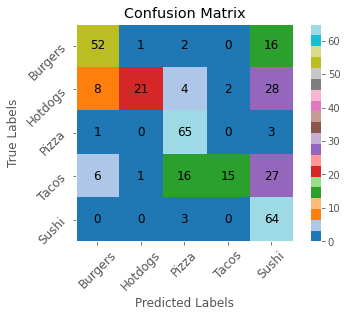

In [34]:
# Plot multiclass confusion matrix
preds4 = effnet.predict(X_test, batch_size=8)
preds4 = np.argmax(preds4, axis=1)

cm4 = confusion_matrix(y_test.argmax(axis=1), preds4)
plt.imshow(cm4, cmap='tab20', interpolation='nearest')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(cm4)), ['Burgers', 'Hotdogs', 'Pizza', 'Tacos', 'Sushi'], rotation=45, size='large')
plt.yticks(np.arange(len(cm4)), ['Burgers', 'Hotdogs', 'Pizza', 'Tacos', 'Sushi'], rotation=45, size='large')
plt.grid(None)
plt.colorbar()

for i in range(len(cm4)):
    for j in range(len(cm4)):
        plt.text(j, i, cm4[i, j], ha='center', va='center', size='large')

plt.show()

**Interpretation:** A multiclass confusion matrix has been plotted above. The EfficientNet-B0 model performed the best at correctly predicting pizza and sushi. The model appears to have struggled with identifying sushi as it predicted sushi in many cases when the image was something else.

### Production Model
Model 4 is my choice for the production model. While recall and precision are important classification metrics, accuracy is the most relevant to the problem statement in this project, which involves predicting the correct food class for each image. The baseline accuracy I sought to beat is 21.06% since burgers constitute the majority class. After 25 epochs, Model 1 achieved a validation accuracy of 45.37%, Model 2 attained 33.13%, Model 3 reached 28.66%, and Model 4 achieved 64.78%. Since the predictive capability of the model is key to the objective, Model 4 is the most suitable to be the production model.

### Executive Summary
Using fewer than 300 images per class, my production model achieved an accuracy of 64.78% on unseen data for a multiclass image classification problem. The convolutional neural network made from Google's pre-trained EfficientNet-B0 model utilized image data augmentation to enhance its performance. The model performed the best when predicting pizza and sushi and performed the worst at predicting sushi. I also implemented IBM's pre-trained ResNet50 model in a transfer learning environment, but the model failed to achieve a higher validation accuracy than the production model in the designated 25 epochs.

### Exploratory Data Analysis (EDA)

**Note:** No dataframe was used to build any of the convolutional neural networks.

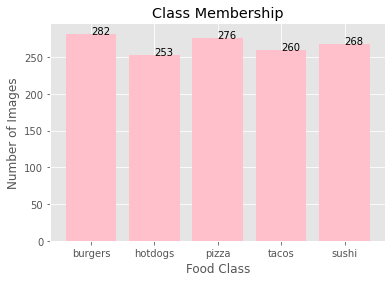

In [35]:
# x-axis
food_classes = ['burgers', 'hotdogs', 'pizza', 'tacos', 'sushi']

# y-axis
number_of_images = [282, 253, 276, 260, 268]

# Barplot of class membership
plt.title('Class Membership')
plt.xlabel('Food Class')
plt.ylabel('Number of Images')
plt.bar(food_classes, number_of_images, color='pink')

# Referenced: https://www.geeksforgeeks.org/how-to-display-the-value-of-each-bar-in-a-bar-chart-using-matplotlib/
# Label values
for index, value in enumerate(number_of_images):
    plt.text(index, value, str(value))
plt.show();

**Interpretation:** The majority class was burgers.

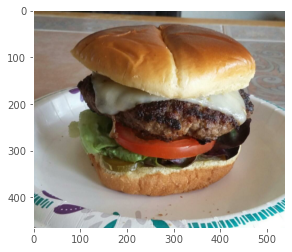

In [36]:
# Example of a burger image
burger_demo = load_img('../images/burgers/burgers_14.png')
burger_demo_array = img_to_array(burger_demo)
plt.imshow(burger_demo_array/255)
plt.grid(None);

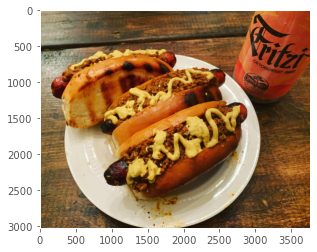

In [37]:
# Example of a hotdog image
hotdog_demo = load_img('../images/hotdogs/hotdogs_101.jpg')
hotdog_demo_array = img_to_array(hotdog_demo)
plt.imshow(hotdog_demo_array/255)
plt.grid(None);

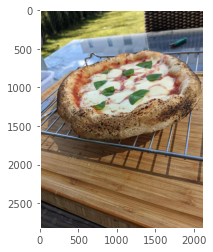

In [38]:
# Example of a pizza image
pizza_demo = load_img('../images/pizza/pizza_100.jpg')
pizza_demo_array = img_to_array(pizza_demo)
plt.imshow(pizza_demo_array/255)
plt.grid(None);

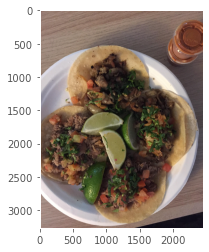

In [39]:
# Example of a taco image
taco_demo = load_img('../images/tacos/tacos_202.jpg')
taco_demo_array = img_to_array(taco_demo)
plt.imshow(taco_demo_array/255)
plt.grid(None);

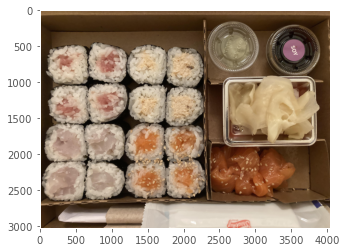

In [40]:
# Example of a sushi image
sushi_demo = load_img('../images/sushi/sushi_104.jpg')
sushi_demo_array = img_to_array(sushi_demo)
plt.imshow(sushi_demo_array/255)
plt.grid(None);

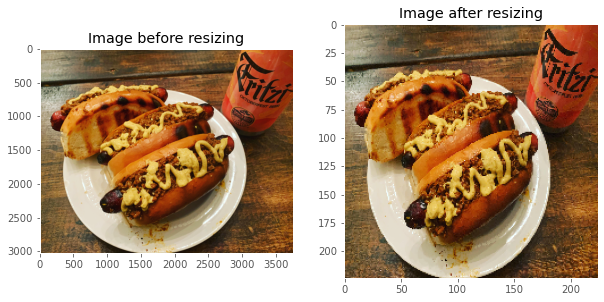

In [41]:
# Referenced: https://stackoverflow.com/questions/42818361/how-to-make-two-plots-side-by-side-using-python/42818501
# Subplot showing image before and after resizing
plt.figure(figsize=(10,10))

# Image before resizing
plt.subplot(1,2,1)
plt.title('Image before resizing')
plt.imshow(hotdog_demo_array/255)
plt.grid(None)

# Image after resizing
plt.subplot(1,2,2)
plt.title('Image after resizing')
image_path = '../images/hotdogs/hotdogs_101.jpg'
resized_image = load_img(image_path, target_size=(224, 224))
resized_image_arr = img_to_array(resized_image) / 255
plt.imshow(resized_image_arr)
plt.grid(None)

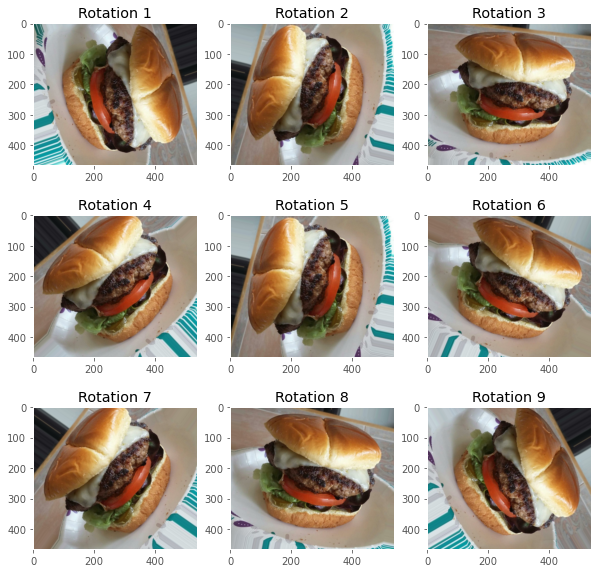

In [42]:
# Referenced: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
# Example of image data augmentation - random rotation
ex_img = load_img('../images/burgers/burgers_14.png')
data = img_to_array(ex_img)
sample = expand_dims(data, 0)
aug_gen = ImageDataGenerator(rotation_range=90)
it = aug_gen.flow(sample, batch_size=1)
plt.figure(figsize=(10,10))

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    img = batch[0].astype('uint8')
    plt.grid(None)
    plt.title(f'Rotation {i+1}')
    plt.imshow(img)

plt.show();

#### -- End of Notebook --